#### Imports ####

In [1]:
import os
import torch
import numpy as np
import normflows as nf
import hydra
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.stats import kendalltau

from flows import RealNVP, NeuralSplineFlow
from prefflow import PrefFlow
from plotter import Plotter
from target import set_up_problem
from misc import convert_to_ranking
from pcbo_dataset import PCBO_SyntheticDataset
from torch.utils.data import DataLoader
from dag_visual import plot_dag
from parent_posterior import ParentPosterior
from acquisition import pig_pairwise

#### Load config file to set-up experiment and algorithm details ####

In [2]:
with hydra.initialize(version_base=None, config_path="conf"):
   os.chdir(os.getcwd())
   output_folder = os.path.join(os.getcwd(), 'temporary_outputs')
   cfg = hydra.compose(config_name="config.yaml",overrides=["+db=mysql"])
if not cfg.plot.showduringtraining: # Show plots?
    matplotlib.use('Agg') 

#### Device and Precision ####

In [3]:
torch.set_default_dtype(torch.float64 if cfg.device.precision_double else torch.float32)
device = torch.device(cfg.device.device)

#### Random seeds ####

In [4]:
import random
torch.manual_seed(cfg.exp.seed)
np.random.seed(cfg.exp.seed)
random.seed(cfg.exp.seed)

### Data Generation

In [5]:
D = cfg.exp.d  # Dimension of the input space
ranking = cfg.data.k > 2  # Is it a ranking problem?
dataset = PCBO_SyntheticDataset(n_queries=cfg.data.n, k=cfg.data.k, d=D)
dataloader = DataLoader(dataset, batch_size=cfg.params.batch_size, shuffle=True)

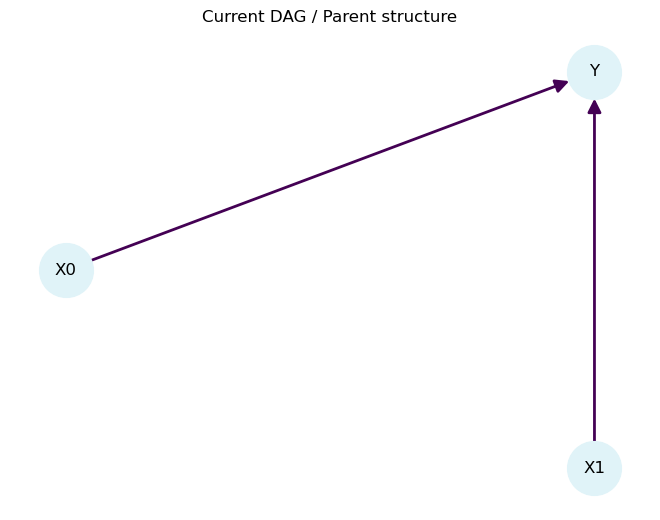

In [6]:
plot_dag(dataset.adj.numpy(), dataset.node_names)

#### Base distribution and Flow architecture ####

In [7]:
q0 = nf.distributions.DiagGaussian(D, trainable=False)
nflows = cfg.params.nflows
if cfg.params.flow == "realnvp":
    nfm = RealNVP(nflows,D,q0,device,cfg.device.precision_double)
if cfg.params.flow == "neuralsplineflow":
    nfm = NeuralSplineFlow(nflows,D,q0,device,cfg.device.precision_double)

In [8]:
def minibatch(dataloader, ranking):
    x_choices, winner_indices = next(iter(dataloader))  # (B, k, d), (B,)
    x_choices = x_choices.permute(1,2,0)  # (k, d, B)

    if ranking:
        # pass only tensor of alternatives
        return x_choices  # shape (k, d, B)
    else:
        # pairwise expects a tuple (X_raw, Y)
        return x_choices, winner_indices

  #### Initialize preferential flow ####

In [9]:
prefflow = PrefFlow(nfm,D=D,s=cfg.modelparams.s,ranking=ranking,device=device,precision_double=cfg.device.precision_double)

#### Initialize optimizer ####

In [10]:
loss_hist = np.array([])
batch_size = cfg.params.batch_size
optimizer = getattr(torch.optim, cfg.params.optimizer.capitalize())
optimizer_prefflow = optimizer([{'params':prefflow.parameters()}],lr=cfg.params.lr, weight_decay=cfg.params.weight_decay)

### Parent Posterior

In [11]:
ppost = ParentPosterior(d=D, sigma_eps=0.1, sigma_theta=1.0, prior_sparsity=0.3)

causal_update_every = 1  # how often to normalise & log edge probabilities

### SGD FS-MAP + Causal Update Loop

In [12]:
# for it in tqdm(range(cfg.params.max_iter), disable=not cfg.plot.progressbar_show):
    
#     # Sample minibatch
#     batch = minibatch(dataloader, ranking)  
#     if	ranking:  # Ranking case
#         X_raw = batch
#         x_win = X_raw[0, :, 0]  # Winner of first sample (first alternative)
#     else:  # Pairwise case
#         X_raw, winner_idx = batch 
#         win_first = (winner_idx[0].item() == 1)  # Look at first sample
#         if win_first:  # If winner is first alternative
#             x_win = X_raw[0, :, 0]
#         else:
#             x_win = X_raw[1, :, 0]

#     # PNF Step
#     prefflow.train()
#     optimizer_prefflow.zero_grad()
#     loss = -prefflow.logposterior(batch, cfg.modelparams.weightprior)
#     if ~(torch.isnan(loss) | torch.isinf(loss)):
#         loss.backward()
#         optimizer_prefflow.step()
#     loss_hist = np.append(loss_hist, loss.item())

#     # Causal Update
#     with torch.no_grad():
#         y_win_val = dataset.scm(x_win.unsqueeze(0))[0].item()  # scalar
#     ppost.add_datapoint(x_win.unsqueeze(0), y_win_val)

#     if (it + 1) % causal_update_every == 0:
#         ppost.update_posterior()
#         edge_probs = ppost.edge_posterior()
#         print(f"[{it+1}] loss={loss.item():.3f}   edge P: {edge_probs.numpy()}")

#     # (optional) plot every N iters
#     # if (it+1) % cfg.plot.show_iter == 0:
#     #     adj = np.array([[0,0,1],[0,0,1],[0,0,0]])
#     #     edge_mat = np.array([[0,0,edge_probs[0]],
#     #                          [0,0,edge_probs[1]],
#     #                          [0,0,0]])
#     #     plot_dag(adj, names=["X1","X2","Y"], edge_probs=edge_mat)

## PIG Loop (k=2) + Causal Updates

In [13]:
def _test_batch_consistency():
    x_anchor  = torch.randn(1,D)
    x_oppo    = torch.randn(1,D)
    # Build batch exactly like in the loop
    X_pair = torch.vstack([x_anchor, x_oppo])
    y_vals = dataset.scm(X_pair)
    winner_first = int(y_vals[0] < y_vals[1])
    Y_label = torch.tensor([winner_first])
    batch = (X_pair.T.unsqueeze(-1), Y_label)

    # Check PrefFlow sees the same order:
    logf,_ = prefflow.f(X_pair)
    p0 = torch.sigmoid((logf[0]-logf[1])/prefflow.s).item()
    print("True winner =", winner_first,
          "| model p(anchor wins) =", f"{p0:.3f}")

In [14]:
domain_low, domain_high = dataset.domain
def sample_uniform(n):
    return (torch.rand(n, D, device=device) *
            (domain_high - domain_low) + domain_low)

causal_update_every = 50
loss_hist = []

for it in tqdm(range(cfg.params.max_iter), disable=not cfg.plot.progressbar_show):

    # ───────────── acquire a pair via PIG ──────────────
    if ranking:  # k > 2
								# keep original ranking minibatch
        xb, win_idx = next(iter(dataloader))  # (B,k,d) , (B,)
        X_choices = xb.permute(1,2,0)  # (k, d, B)
        batch = X_choices
        x_win  = X_choices[0,:,0]  # top ranked
    else:  # PIG for pairwise
        # anchor + 150 candidates
        x_anchor = sample_uniform(1)  # (1,d)
        candidates = sample_uniform(150)  # (N,d)
        ig_vals = pig_pairwise(prefflow, x_anchor, candidates, s=float(prefflow.s))
        x_oppo = candidates[int(np.argmax(ig_vals))].unsqueeze(0)  # (1,d)

        # true outcome -> lower Y is better
        with torch.no_grad():
            y_vals = dataset.scm(torch.vstack([x_anchor, x_oppo]))
        winner_first = int(y_vals[0] < y_vals[1])
        Y_label = torch.tensor([winner_first], device=device, dtype=torch.long)

        X_pair = torch.vstack([x_anchor, x_oppo])  # (2,d)
        batch = (X_pair.T.unsqueeze(-1), Y_label)  # (2,d,1), (1,)
        x_win = X_pair[0] if winner_first else X_pair[1]  # (d,)

    # ─────────────  PrefFlow step  ──────────────
    optimizer_prefflow.zero_grad()
    loss = -prefflow.logposterior(batch, cfg.modelparams.weightprior)
    if torch.isfinite(loss):
        loss.backward()
        optimizer_prefflow.step()
    loss_hist.append(loss.item())

    # ─────────────  Causal posterior  ───────────
    with torch.no_grad():
        y_win_val = dataset.scm(x_win.unsqueeze(0))[0].item()
    ppost.add_datapoint(x_win.unsqueeze(0), y_win_val)
    
				# test consistency every 500 iterations
    if (it + 1) % 500 == 0:
        _test_batch_consistency()

    if (it + 1) % causal_update_every == 0:
        ppost.update_posterior()
        edge_probs = ppost.edge_posterior()
        print(f"[{it+1:5}]  loss={loss.item():.3f}   edge P = {edge_probs.numpy()}")

  3%|▎         | 53/2000 [00:02<01:17, 25.26it/s]

[   50]  loss=8.228   edge P = [1. 1.]


  5%|▌         | 104/2000 [00:04<01:13, 25.77it/s]

[  100]  loss=4.875   edge P = [1. 1.]


  8%|▊         | 155/2000 [00:06<01:12, 25.60it/s]

[  150]  loss=6.826   edge P = [1. 1.]


 10%|█         | 203/2000 [00:08<01:10, 25.64it/s]

[  200]  loss=6.697   edge P = [1. 1.]


 13%|█▎        | 254/2000 [00:10<01:08, 25.51it/s]

[  250]  loss=7.069   edge P = [1. 1.]


 15%|█▌        | 305/2000 [00:12<01:08, 24.87it/s]

[  300]  loss=5.174   edge P = [1. 1.]


 18%|█▊        | 353/2000 [00:13<01:03, 25.74it/s]

[  350]  loss=3.903   edge P = [1. 1.]


 20%|██        | 404/2000 [00:15<01:03, 25.22it/s]

[  400]  loss=4.473   edge P = [1. 1.]


 23%|██▎       | 455/2000 [00:18<01:01, 25.27it/s]

[  450]  loss=8.630   edge P = [1. 1.]


 25%|██▌       | 503/2000 [00:19<00:58, 25.52it/s]

True winner = 1 | model p(anchor wins) = 0.990
[  500]  loss=6.356   edge P = [1. 1.]


 28%|██▊       | 554/2000 [00:21<00:55, 25.89it/s]

[  550]  loss=7.071   edge P = [1. 1.]


 30%|███       | 605/2000 [00:23<00:53, 25.90it/s]

[  600]  loss=3.528   edge P = [1. 1.]


 33%|███▎      | 653/2000 [00:25<00:52, 25.69it/s]

[  650]  loss=9.128   edge P = [1. 1.]


 35%|███▌      | 704/2000 [00:27<00:51, 25.38it/s]

[  700]  loss=3.859   edge P = [1. 1.]


 38%|███▊      | 755/2000 [00:29<00:48, 25.61it/s]

[  750]  loss=5.373   edge P = [1. 1.]


 40%|████      | 803/2000 [00:31<00:48, 24.78it/s]

[  800]  loss=3.213   edge P = [1. 1.]


 43%|████▎     | 854/2000 [00:33<00:46, 24.89it/s]

[  850]  loss=4.272   edge P = [1. 1.]


 45%|████▌     | 905/2000 [00:35<00:43, 25.30it/s]

[  900]  loss=3.765   edge P = [1. 1.]


 48%|████▊     | 953/2000 [00:37<00:45, 23.12it/s]

[  950]  loss=5.910   edge P = [1. 1.]


 50%|█████     | 1004/2000 [00:39<00:42, 23.61it/s]

True winner = 0 | model p(anchor wins) = 0.349
[ 1000]  loss=3.457   edge P = [1. 1.]


 53%|█████▎    | 1055/2000 [00:41<00:37, 25.38it/s]

[ 1050]  loss=3.134   edge P = [1. 1.]


 55%|█████▌    | 1103/2000 [00:43<00:34, 25.64it/s]

[ 1100]  loss=4.391   edge P = [1. 1.]


 58%|█████▊    | 1154/2000 [00:45<00:34, 24.68it/s]

[ 1150]  loss=2.605   edge P = [1. 1.]


 60%|██████    | 1205/2000 [00:47<00:31, 24.92it/s]

[ 1200]  loss=7.197   edge P = [1. 1.]


 63%|██████▎   | 1253/2000 [00:49<00:29, 25.23it/s]

[ 1250]  loss=5.801   edge P = [1. 1.]


 65%|██████▌   | 1304/2000 [00:51<00:27, 24.87it/s]

[ 1300]  loss=3.011   edge P = [1. 1.]


 68%|██████▊   | 1355/2000 [00:53<00:26, 24.79it/s]

[ 1350]  loss=4.125   edge P = [1. 1.]


 70%|███████   | 1403/2000 [00:55<00:23, 25.34it/s]

[ 1400]  loss=12.633   edge P = [1. 1.]


 73%|███████▎  | 1454/2000 [00:57<00:21, 25.02it/s]

[ 1450]  loss=2.773   edge P = [1. 1.]


 75%|███████▌  | 1502/2000 [00:59<00:20, 23.86it/s]

True winner = 1 | model p(anchor wins) = 0.656
[ 1500]  loss=4.385   edge P = [1. 1.]


 78%|███████▊  | 1553/2000 [01:01<00:17, 25.29it/s]

[ 1550]  loss=4.951   edge P = [1. 1.]


 80%|████████  | 1604/2000 [01:04<00:16, 24.01it/s]

[ 1600]  loss=6.269   edge P = [1. 1.]


 83%|████████▎ | 1655/2000 [01:06<00:13, 25.05it/s]

[ 1650]  loss=1.804   edge P = [1. 1.]


 85%|████████▌ | 1703/2000 [01:08<00:11, 24.85it/s]

[ 1700]  loss=2.903   edge P = [1. 1.]


 88%|████████▊ | 1754/2000 [01:10<00:10, 24.54it/s]

[ 1750]  loss=5.146   edge P = [1. 1.]


 90%|█████████ | 1805/2000 [01:12<00:07, 24.81it/s]

[ 1800]  loss=6.403   edge P = [1. 1.]


 93%|█████████▎| 1853/2000 [01:14<00:06, 23.59it/s]

[ 1850]  loss=4.776   edge P = [1. 1.]


 95%|█████████▌| 1904/2000 [01:16<00:03, 24.90it/s]

[ 1900]  loss=5.771   edge P = [1. 1.]


 98%|█████████▊| 1952/2000 [01:18<00:01, 25.00it/s]

[ 1950]  loss=3.714   edge P = [1. 1.]


100%|██████████| 2000/2000 [01:20<00:00, 24.96it/s]

True winner = 0 | model p(anchor wins) = 0.815
[ 2000]  loss=4.410   edge P = [1. 1.]


#### Plot loss trajectory ####

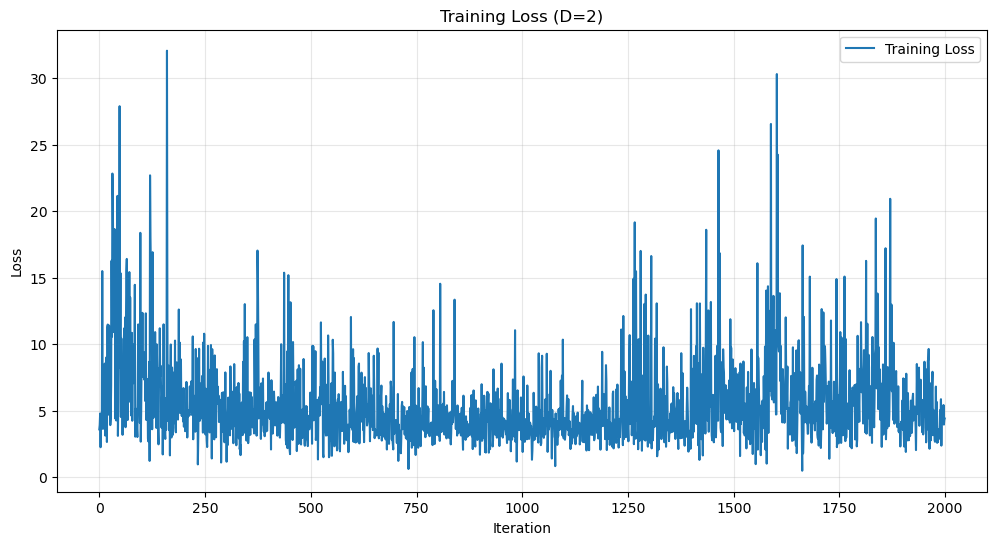

In [15]:
# -------- 1. Plot Learning Curve --------
plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Training Loss')
plt.title(f"Training Loss (D={D})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

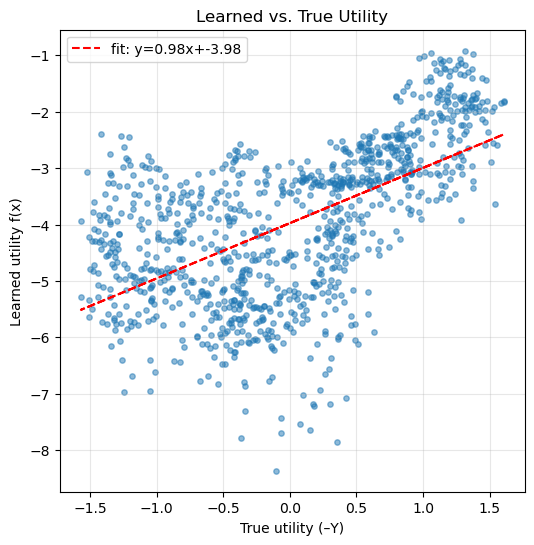

In [16]:
# ---- after training ----
import matplotlib.pyplot as plt

# 1. Sample a bunch of random interventions
N_vis = 1000
# domain = [−2,2] in each dimension (same as PCBO_SyntheticDataset)
X_vis = (torch.rand(N_vis, D) * (dataset.domain[1] - dataset.domain[0])
         + dataset.domain[0]).to(device)

# 2. Compute true utility and learned utility
with torch.no_grad():
    Y_vis = dataset.scm(X_vis)
    logf_vis, _ = prefflow.f(X_vis)
    u_true = (-Y_vis).cpu().numpy()
    u_learn = logf_vis.cpu().numpy()

# 3. Scatter
plt.figure(figsize=(6,6))
plt.scatter(u_true, u_learn, alpha=0.5, s=15)
m, b = np.polyfit(u_true, u_learn, 1)
plt.plot(u_true, m*u_true+b, 'r--', label=f'fit: y={m:.2f}x+{b:.2f}')
plt.xlabel('True utility (–Y)')
plt.ylabel('Learned utility f(x)')
plt.title('Learned vs. True Utility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

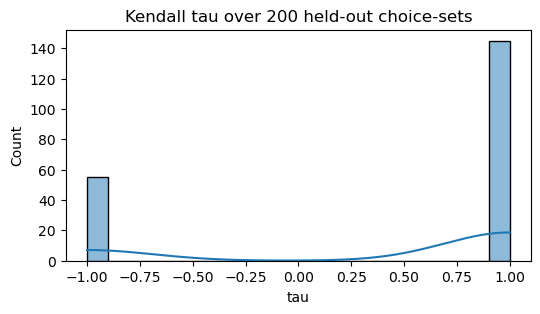

Mean tau: 0.45


In [17]:
import seaborn as sns
from scipy.stats import kendalltau

def ranking_tau(prefflow, dataset, n_trials=200):
    taus = []
    for _ in range(n_trials):
        # sample one fresh query
        Xk, _, Yk = dataset._generate_one_query()  # now returns (k,d), idx, (k,)
        
        # true utility = –Yk
        u_true = (-Yk).cpu().numpy()
        
        # learned utility f(x)
        with torch.no_grad():
            logf, _ = prefflow.f(Xk.to(prefflow.device))  # shape (k,)
            u_learn = logf.cpu().numpy()
        
        tau, _ = kendalltau(u_true, u_learn)
        taus.append(tau)
    return np.array(taus)

taus = ranking_tau(prefflow, dataset, n_trials=200)
plt.figure(figsize=(6,3))
sns.histplot(taus, kde=True, bins=20)
plt.title(f'Kendall tau over {len(taus)} held-out choice-sets')
plt.xlabel('tau'); plt.ylabel('Count')
plt.show()
print('Mean tau:', taus.mean())

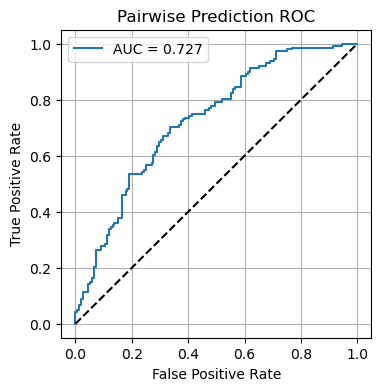

In [18]:
from sklearn.metrics import roc_curve, auc

# Build a test set of pairwise comps
probs, labels = [], []
for _ in range(300):
    # sample 2 interventions
    X2 = (torch.rand(2, D)*(dataset.domain[1]-dataset.domain[0]) + dataset.domain[0]).to(device)
    Y = dataset.scm(X2).cpu().numpy()
    true_label = 1 if Y[0]<Y[1] else 0  # “1” means index 0 wins
    # model’s probability index 0 wins:
    with torch.no_grad():
        logf, _ = prefflow.f(X2)
        p0 = torch.sigmoid((logf[0]-logf[1])/prefflow.s).cpu().item()
    probs.append(p0)
    labels.append(true_label)

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Pairwise Prediction ROC')
plt.legend(); plt.grid(True)
plt.show()

### Visualise DAG with posterior edge weights

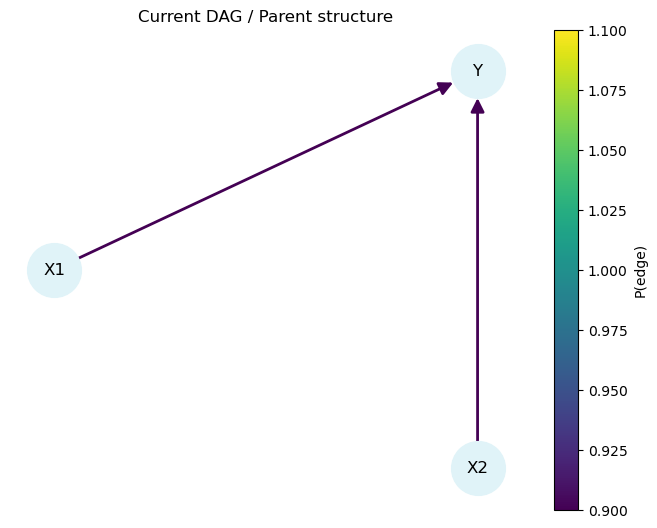

In [19]:
adj = np.array([[0,0,1],
                [0,0,1],
                [0,0,0]])
edge_probs = np.array([[0,0,ppost.edge_posterior()[0]],
                       [0,0,ppost.edge_posterior()[1]],
                       [0,0,0]])
plot_dag(adj, names=["X1","X2","Y"], edge_probs=edge_probs)